 # 1. Import and Install Dependencies

In [163]:
# !pip install tensorflow==2.16.1 opencv-python mediapipe scikit-learn matplotlib keras==3.0qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq

In [2]:
import cv2
import numpy as np
import os

from keras.src.callbacks import CSVLogger
from keras.src.layers import Masking
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2024-06-01 13:13:02.426415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 13:13:03.485471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
actions = np.array(['hallo', 'du','idle','a'])

# Change the action name for each new action

# 2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Mirror the frame
        frame = cv2.flip(frame, 1)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        cap.release()
        cv2.destroyAllWindows()
cap.release()
cv2.destroyAllWindows()

I0000 00:00:1717240385.262712   26969 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717240385.265454   27145 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 15.0.7, DRM 3.57, 6.8.0-76060800daily20240311-generic)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>


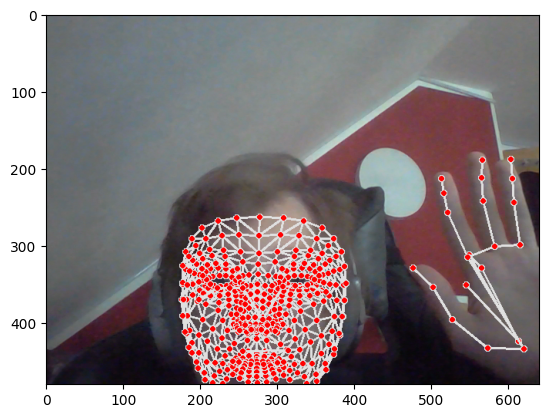

In [5]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [6]:
if results.left_hand_landmarks is not None:
    len(results.left_hand_landmarks.landmark)
else:
    print("No left hand detected.")
    
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
else:
    np.zeros(1404)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [7]:
result_test = extract_keypoints(results)
result_test
np.save('0', result_test)
np.load('SavedModels/0.npy')

array([ 0.34197718,  0.5891912 , -0.61386597, ...,  0.        ,
        0.        ,  0.        ])

In [8]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('CollectionBase/MP_Data/30frame_no_face_+idle')

# 30 sequences worth of data
no_sequences = 30

# Each sequence 30 frames in length
sequence_length = 30
# Folder start
start_folder = 0

# 6. Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical


In [10]:
label_map = {label:num for num, label in enumerate(actions)}

In [11]:
label_map

{'hallo': 0, 'du': 1, 'idle': 2, 'a': 3}

In [12]:
sequences, labels = [], []
print(os.getcwd())
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        #print(len(sequences[0]))
        labels.append(label_map[action])
#print(len(sequences))

/home/eelam/Desktop/AI/attempt2/AiSignLanguage


In [13]:
np.array(sequences).shape

(120, 30, 258)

In [14]:
np.array(labels).shape

(120,)

In [15]:
X = np.array(sequences)

In [16]:
X.shape

(120, 30, 258)

In [17]:
y = to_categorical(labels).astype(int)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [19]:
X_train.shape

(114, 30, 258)

In [20]:
X_test.shape

(6, 30, 258)

In [21]:
y_test.shape

(6, 4)

In [22]:
y_train.shape

(114, 4)

# 7. Build and Train LSTM Neural Network

In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard


In [186]:
log_dir = os.path.join('CollectionBase/Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [211]:

model = Sequential()
model.add(Input(shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='relu', name='lstm1'))
model.add(Dense(64, activation='relu', name='dense1'))
model.add(LSTM(128, return_sequences=True, activation='relu', name='lstm2'))
model.add(Dense(64, activation='relu', name='dense2'))
model.add(LSTM(64, return_sequences=False, activation='relu', name='lstm3'))
model.add(Dense(32, activation='relu', name='dense3'))
model.add(Dense(actions.shape[0], activation='softmax', name='output'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=150, callbacks=[tb_callback])
model.summary() 


Training with batch size: 8
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2622 - loss: 2.2670 - val_accuracy: 0.0000e+00 - val_loss: 5.3891 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3120 - loss: 2.0536 - val_accuracy: 0.1667 - val_loss: 30.8214 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2668 - loss: 2.1702 - val_accuracy: 0.0000e+00 - val_loss: 79.8644 - learning_rate: 0.0010
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2423 - loss: 2.4662 - val_accuracy: 0.3333 - val_loss: 8.3779 - learning_rate: 0.0010
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2699 - loss: 2.5821 - val_accuracy: 0.3333 - val_loss: 1.2018 - learning_rate: 0.0010
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2891 - loss: 2.3849 - val_accuracy: 0.5000 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste

# 8. Make Predictions

In [188]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [189]:
actions[np.argmax(res[3])]

'du'

In [190]:
actions[np.argmax(y_test[3])]

'idle'

# 9. Save Weights

In [199]:
import uuid

# Generate a random UUID
model_uuid = uuid.uuid4()

# Convert the UUID to a string and use it as the model name
model.save(f'{model_uuid}.h5')

In [200]:
del model

In [201]:
model = Sequential()
model.add(Input(shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='relu', name='lstm1'))
model.add(Dense(64, activation='relu', name='dense1'))
model.add(LSTM(128, return_sequences=True, activation='relu', name='lstm2'))
model.add(Dense(64, activation='relu', name='dense2'))
model.add(LSTM(64, return_sequences=False, activation='relu', name='lstm3'))
model.add(Dense(32, activation='relu', name='dense3'))
model.add(Dense(actions.shape[0], activation='softmax', name='output'))
model.load_weights(f'myai.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [6]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [7]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


In [8]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [9]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [1, 1]],

       [[1, 2],
        [0, 3]],

       [[5, 0],
        [1, 0]]])

In [10]:
accuracy_score(ytrue, yhat)

0.6666666666666666

# 11. Test in Real Time

In [ ]:
from scipy import stats

In [221]:
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    # Ensure that the size of 'res' and 'colors' is the same
    if len(res) != len(colors):
        print("Size of 'res' and 'colors' does not match. Please check your inputs.")
        return output_frame
    for num, prob in enumerate(res):
        max_prob = np.max(prob)  # get the maximum probability
        cv2.rectangle(output_frame, (0,60+num*40), (int(max_prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [ ]:
colors = [(245,117,16), (117,245,16), (80,22,10), (121,22,76)]
cap = cv2.VideoCapture(0)  # Start the webcam
ret, image = cap.read()  # Read a frame from the webcam
cap.release()  # Close the webcam

plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
'''
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
'''

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    collecting = False
    frame_count = 0
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Check if 'g' is pressed
        if cv2.waitKey(10) & 0xFF == ord('g'):
            collecting = True
            sequence = []  # Reset the sequence
            frame_count = 0  # Reset the frame count

        # 2. Prediction logic
        if collecting and frame_count < 30:
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            frame_count += 1

            if frame_count == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))
                collecting = False  # Stop collecting after 30 frames

                #3. Viz logic
                if np.unique(predictions[-10:])[0]==np.argmax(res):
                    if res[np.argmax(res)] > threshold:

                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# 12. The fuckening

In [8]:
# Fitting.py

# 1. Import necessary libraries
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, Input

# 2. Define actions
actions = np.array(['hallo', 'du', 'idle', 'a'])

# 3. Load data
DATA_PATH = 'CollectionBase/MP_Data'
sequence_length = 60
no_sequences = 30

label_map = {label:num for num, label in enumerate(actions)}
# Load data
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Balance the dataset using SMOTE
X = X.reshape((X.shape[0], -1))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, labels)
X_res = X_res.reshape((X_res.shape[0], sequence_length, -1))
y_res = to_categorical(y_res).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

'''
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(sequence_length, X_res.shape[-1])))
model.add(LSTM(64, return_sequences=True, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

'''


model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(sequence_length, X_res.shape[-1])))
model.add(LSTM(64, return_sequences=True, activation='relu', name='lstm1'))
model.add(Dense(64, activation='relu', name='dense1'))
model.add(LSTM(128, return_sequences=True, activation='relu', name='lstm2'))
model.add(Dense(64, activation='relu', name='dense2'))
model.add(LSTM(64, return_sequences=False, activation='relu', name='lstm3'))
model.add(Dense(32, activation='relu', name='dense3'))
model.add(Dense(actions.shape[0], activation='softmax', name='output'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

log_dir = os.path.join('CollectionBase/Logs')
tb_callback = TensorBoard(log_dir=log_dir)

history = model.fit(X_train, y_train, epochs=300, batch_size=64, callbacks=[tb_callback], validation_split=0.1)



y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Confusion Matrix:")
print(multilabel_confusion_matrix(y_true_classes, y_pred_classes))
print("Accuracy Score:")
print(accuracy_score(y_true_classes, y_pred_classes))
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=actions))


# 9. Save the model
model.save('my_model.h5')


/home/eelam/Downloads/.venv/lib/python3.10/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - categorical_accuracy: 0.2799 - loss: 1.4419 - val_categorical_accuracy: 0.2000 - val_loss: 3.0768
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - categorical_accuracy: 0.2564 - loss: 10.8573 - val_categorical_accuracy: 0.2000 - val_loss: 30.5318
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - categorical_accuracy: 0.2098 - loss: 38.1952 - val_categorical_accuracy: 0.4000 - val_loss: 29.2658
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_accuracy: 0.3938 - loss: 72.1706 - val_categorical_accuracy: 0.2000 - val_loss: 332.1235
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_accuracy: 0.2099 - loss: 170.7117 - val_categorical_accuracy: 0.4000 - val_loss: 127.3105
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - categorical_accuracy: 0.2330 - loss: 81.6135 - val_categorical_accuracy: 0.1000 - val_loss: 198.8307
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - categorical_accuracy: 0.2798

/home/eelam/Downloads/.venv/lib/python3.10/site-packages/keras/src/models/model.py:342: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  warnings.warn(


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
import cv2 as cv2


# 13. Testing the Fuckening

In [20]:
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    # Ensure that the size of 'res' and 'colors' is the same
    if len(res) != len(colors):
        print("Size of 'res' and 'colors' does not match. Please check your inputs.")
        return output_frame
    for num, prob in enumerate(res):
        max_prob = np.max(prob)  # get the maximum probability
        cv2.rectangle(output_frame, (0,60+num*40), (int(max_prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame
colors = [(245,117,16), (117,245,16), (80,22,10), (121,22,76)]
cap = cv2.VideoCapture(0)  # Start the webcam
ret, image = cap.read()  # Read a frame from the webcam
cap.release()  # Close the webcam

#plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    collecting = False
    frame_count = 0
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Check if 'g' is pressed
        if cv2.waitKey(10) & 0xFF == ord('g'):
            collecting = True
            sequence = []  # Reset the sequence
            frame_count = 0  # Reset the frame count

        # 2. Prediction logic
        if collecting and frame_count < 30:
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            frame_count += 1

            if frame_count == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))
                collecting = False  # Stop collecting after 30 frames

                #3. Viz logic
                if np.unique(predictions[-10:])[0]==np.argmax(res):
                    if res[np.argmax(res)] > threshold:

                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

# Other version

In [ ]:
def draw_landmarks(image, results):
 #   mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
   # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
   #                           mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
     #                         )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                              )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                              )
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )

In [1]:
shape_no_face = (30, 258)
num_classes = 4
actions = ['hallo','du','idle','a']  # List all your actions including idle
DATA_PATH = 'CollectionBase/MP_Data/30frame_no_face_+idle'  # Update with your data path
sequence_length = 30  # Number of frames per sequence

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paths and parameters

# Initialize sequences and labels
sequences, labels = [], []

# Create a mapping of labels to numbers
label_map = {label: num for num, label in enumerate(actions)}

# Loop through each action and each sequence within that action
for action in actions:
    action_dir = os.path.join(DATA_PATH, action)
    for sequence in np.array(os.listdir(action_dir)).astype(int):
        window = []
        for frame_num in range(sequence_length):
            frame_path = os.path.join(action_dir, str(sequence), f"{frame_num}.npy")
            res = np.load(frame_path)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Convert sequences and labels to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Print the shape of the data
print(f"Total sequences: {len(sequences)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


2024-06-01 13:19:02.104512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 13:19:02.861811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Total sequences: 120
X shape: (120, 30, 258)
y shape: (120, 4)
X_train shape: (114, 30, 258), y_train shape: (114, 4)
X_test shape: (6, 30, 258), y_test shape: (6, 4)


In [15]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization


# Define the number of classes including the idle state
num_classes = len(actions)  # Should be 101

model = Sequential()

# Input layer
model.add(Input(shape=shape_no_face))

# Adding LSTM layers
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Fully connected layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer for num_classes
model.add(Dense(num_classes, activation='softmax'))

# Set up CSVLogger
csv_logger = CSVLogger('training_log.csv', append=True)

# Set up TensorBoard
log_dir = os.path.join("logs", "fit", "sign_language_recognition")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# List of callbacks
callbacks = [csv_logger, tensorboard_callback]


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - accuracy: 0.4372 - loss: 1.2425 - val_accuracy: 1.0000 - val_loss: 1.2382
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7918 - loss: 0.5413 - val_accuracy: 1.0000 - val_loss: 1.1824
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8873 - loss: 0.3579 - val_accuracy: 1.0000 - val_loss: 1.1069
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9052 - loss: 0.3074 - val_accuracy: 1.0000 - val_loss: 1.0715
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9494 - loss: 0.1525 - val_accuracy: 0.8333 - val_loss: 1.0832
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9083 - loss: 0.2231 - val_accuracy: 0.6667 - val_loss: 1.0540
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9502 - loss: 0.1352 - val_accuracy: 1.0000 - val_loss: 0.9546
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9909 - loss: 0.0837 - val_accuracy: 0.8333 - val_loss: 0.9734

In [16]:
model.save('my_model.keras')

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load the trained model
model = tf.keras.models.load_model('my_model.keras')

# Actions (signs) list
actions = ['hallo','du','idle','a']  # List all your actions including idle

# Initialize Mediapipe holistic module
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Function to extract keypoints
def extract_keypoints(results):
    keypoints = []
    if results.right_hand_landmarks:
        for landmark in results.right_hand_landmarks.landmark:
            keypoints.extend([landmark.x, landmark.y, landmark.z])
    else:
        keypoints.extend([0] * 21 * 3)
    if results.left_hand_landmarks:
        for landmark in results.left_hand_landmarks.landmark:
            keypoints.extend([landmark.x, landmark.y, landmark.z])
    else:
        keypoints.extend([0] * 21 * 3)
    return keypoints

# Function to visualize probabilities
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    if len(res) != len(colors):
        print("Size of 'res' and 'colors' does not match. Please check your inputs.")
        return output_frame
    for num, prob in enumerate(res):
        max_prob = np.max(prob)
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(max_prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

# Colors for visualization
colors = [(245, 117, 16), (117, 245, 16), (80, 22, 10), (121, 22, 76)]

# Initialize video capture
cap = cv2.VideoCapture(0)

# Set Mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    collecting = False
    frame_count = 0
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)

        # Convert the frame color from BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detections
        results = holistic.process(image)

        # Convert back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks
        #     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

        # Check if 'g' is pressed
        if cv2.waitKey(10) & 0xFF == ord('g'):
            collecting = True
            sequence = []  # Reset the sequence
            frame_count = 0  # Reset the frame count

        # Prediction logic
        if collecting and frame_count < 30:
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            frame_count += 1

            if frame_count == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                collecting = False  # Stop collecting after 30 frames

                # Visualization logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

                # Visualize probabilities
                image = prob_viz(res, actions, image, colors)

        # Display the detected sentence
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


2024-06-01 16:04:44.148571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 16:04:44.920050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-01 16:04:46.369268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 16:04:46.370371: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Fo

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 126 and 258 for '{{node sequential_5_1/lstm_15_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_5_1/lstm_15_1/strided_slice_2, sequential_5_1/lstm_15_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [1,126], [258,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1, 126), dtype=float32)
  • states=('tf.Tensor(shape=(1, 128), dtype=float32)', 'tf.Tensor(shape=(1, 128), dtype=float32)')
  • training=False